In [1]:
import trajectories
import numpy as np
import matplotlib.pyplot as plt
from ctypes import cdll, c_float
%matplotlib inline

In [2]:
LIB_NAME = "../../../build/libekf_python.dylib"

In [3]:
lib = cdll.LoadLibrary(LIB_NAME)

Point = c_float * 2


estimator_predict = lib.estimator_predict
estimator_predict.restype = None

estimator_process_distance_measurement = lib.estimator_process_distance_measurement
estimator_process_distance_measurement.restype = None
estimator_process_distance_measurement.argtypes = (Point, c_float)

estimator_get_x = lib.estimator_get_x
estimator_get_x.restype = c_float

estimator_get_y = lib.estimator_get_y
estimator_get_y.restype = c_float



In [4]:
# Simulation start
f = 200
f_uwb = 10
vmax = 0.4
N = 10000
variance = (vmax / (2 * f_uwb))**2

BEACON_POS = [
    (-1.5, 0),
    (1.5, 1),
    (1.5, -1),
]


x, xhat = [], []
y, yhat = [], []
ts = []



In [5]:
for i, p in zip(range(N), trajectories.generate_circular_traj(1, np.deg2rad(10), 1/f)):
    # feeds the input into Kalman
    estimator_predict()

    if i % (f / f_uwb) == 0:
        for beacon in BEACON_POS:
            z = np.sqrt((beacon[0] - p.pos[0])**2 + (beacon[1] - p.pos[1])**2)
            z += np.random.normal(0, 0.03)
            estimator_process_distance_measurement(Point(*beacon), z)

    # Saves the data
    ts.append(p.timestamp)
    x.append(p.pos[0])
    xhat.append(estimator_get_x())
    y.append(p.pos[1])
    yhat.append(estimator_get_y())



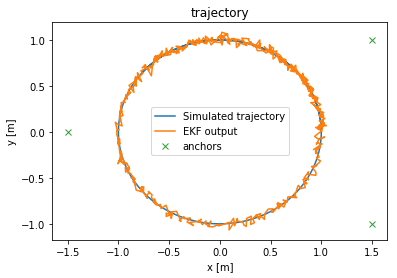

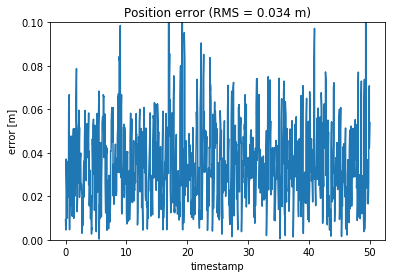

In [6]:
plt.plot(x, y)
plt.plot(xhat, yhat)
plt.plot([x for x, y in BEACON_POS],[y for x, y in BEACON_POS], 'x')
plt.legend(('Simulated trajectory', 'EKF output', 'anchors'))
plt.title('trajectory')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.gcf().savefig('uwb_only_trajectory.pdf')
plt.show()

error = [np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat)]
plt.plot(ts, error)
plt.xlabel('timestamp')
plt.ylabel('error [m]')
plt.ylim(0, 0.1)
plt.title('Position error (RMS = {:.3f} m)'.format(np.mean(error)))
plt.gcf().savefig('uwb_only_error.pdf')
plt.show()